
# PerOmics Hybrid Evaluation: AE + Contrastive + Supervised + ML Classifiers

**Objective:** 
Improve representation learning by combining Autoencoders (Reconstruction), Supervised Contrastive Learning (Alignment), and Focal Loss (Classification Guidance). 
Instead of relying on a single MLP classifier, we use the learned embeddings to train robust classical classifiers (XGBoost, SVM, Logistic Regression).

**Architecture:**
1.  **Encoders (Autoencoders):** Each omic view (RNA, Meth, CNV) has an Encoder-Decoder structure.
    *   *Loss:* Reconstruction Loss (MSE).
2.  **Fusion:** Gated Attention Fusion to combine latent representations.
3.  **Representation Learning Objectives:**
    *   *Contrastive Loss (SupCon):* Aligns samples of the same class in the latent space.
    *   *Focal Loss:* Guides the representation towards class separability (via an auxiliary head).
4.  **Final Classification:**
    *   Extract fused embeddings.
    *   Train XGBoost, SVM, and Logistic Regression.
5.  **Metrics & Clustering:**
    *   Precision, Recall, F1 (Macro/Micro), Accuracy.
    *   Overfitting Check (Train vs Val Loss).
    *   Latent Space Visualization: t-SNE, UMAP.
    *   Clustering Metrics: Silhouette, ARI, NMI.

**Data Pipeline:**
*   GPU-Accelerated mRMR Feature Selection.
*   Stratified 5-Fold Cross-Validation.


In [6]:

import sys
import os
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import KNNImputer
from sklearn.metrics import (
    f1_score, accuracy_score, classification_report, 
    precision_score, recall_score, confusion_matrix,
    silhouette_score, adjusted_rand_score, normalized_mutual_info_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Check for XGBoost
try:
    import xgboost as xgb
    HAS_XGB = True
except ImportError:
    HAS_XGB = False
    print("Warning: xgboost not installed. XGBoost classifier will be skipped.")

# Check for CuPy (GPU mRMR)
try:
    import cupy as cp
    HAS_CUPY = True
    print(">>> CuPy detected. GPU mRMR enabled.")
except ImportError:
    HAS_CUPY = False
    print(">>> CuPy NOT detected. GPU mRMR disabled.")

# Check for mRMR (CPU Fallback)
try:
    from mrmr import mrmr_classif
    HAS_MRMR = True
except ImportError:
    HAS_MRMR = False

# Check for UMAP
try:
    import umap
    HAS_UMAP = True
except ImportError:
    HAS_UMAP = False
    print("Warning: umap-learn not installed.")

# Device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f">>> Running on: {DEVICE}")

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)


>>> CuPy detected. GPU mRMR enabled.
>>> Running on: cuda


In [7]:

# --- GPU Feature Selection Helpers ---

def f_classif_gpu(X, y):
    """Compute ANOVA F-value on GPU."""
    n_samples, n_features = X.shape
    classes = cp.unique(y)
    n_classes = len(classes)
    
    mean_total = cp.mean(X, axis=0)
    var_total = cp.var(X, axis=0)
    ss_total = var_total * n_samples
    
    ss_between = cp.zeros(n_features, dtype=cp.float32)
    
    for c in classes:
        mask = (y == c)
        n_c = cp.sum(mask)
        mean_c = cp.mean(X[mask], axis=0)
        ss_between += n_c * (mean_c - mean_total)**2
        
    ss_within = ss_total - ss_between
    
    df_between = n_classes - 1
    df_within = n_samples - n_classes
    
    ms_between = ss_between / df_between
    ms_within = ss_within / df_within
    
    f_stat = cp.divide(ms_between, ms_within)
    f_stat = cp.nan_to_num(f_stat, nan=0.0)
    return f_stat

def correlation_gpu(X, y):
    """Compute Pearson correlation on GPU."""
    X_centered = X - X.mean(axis=0)
    y_centered = y - y.mean()
    
    numerator = cp.dot(y_centered, X_centered)
    X_ss = cp.sum(X_centered**2, axis=0)
    y_ss = cp.sum(y_centered**2)
    
    denominator = cp.sqrt(X_ss * y_ss)
    corr = numerator / denominator
    return cp.abs(corr)

def mrmr_gpu_impl(X, y, K):
    """GPU accelerated mRMR."""
    X_gpu = cp.asarray(X, dtype=cp.float32)
    y_gpu = cp.asarray(y, dtype=cp.int32)
    
    n_samples, n_features = X_gpu.shape
    
    # 1. Relevance
    relevance = f_classif_gpu(X_gpu, y_gpu)
    
    selected_indices = []
    candidate_mask = cp.ones(n_features, dtype=bool)
    redundancy = cp.zeros(n_features, dtype=cp.float32)
    
    for k in range(K):
        if k == 0:
            scores = relevance
        else:
            scores = relevance - (redundancy / k)
            
        current_scores = scores.copy()
        current_scores[~candidate_mask] = -np.inf 
        
        best_idx = int(cp.argmax(current_scores))
        selected_indices.append(best_idx)
        candidate_mask[best_idx] = False
        
        if k < K - 1:
            last_selected_feature = X_gpu[:, best_idx]
            new_corrs = correlation_gpu(X_gpu, last_selected_feature)
            redundancy += new_corrs
            
    return selected_indices

def variance_filter(train_vals, val_vals, top_k):
    if train_vals.shape[1] <= top_k:
        return train_vals, val_vals, np.arange(train_vals.shape[1])
    vars = np.nanvar(train_vals, axis=0)
    top_idx = np.argpartition(vars, -top_k)[-top_k:]
    top_idx = np.sort(top_idx)
    return train_vals[:, top_idx], val_vals[:, top_idx], top_idx

def mrmr_filter(train_vals, val_vals, train_y, top_k):
    if train_vals.shape[1] <= top_k:
        return train_vals, val_vals, np.arange(train_vals.shape[1])
        
    if HAS_CUPY:
        try:
            selected_indices = mrmr_gpu_impl(train_vals, train_y, top_k)
            if hasattr(selected_indices, 'get'): selected_indices = selected_indices.get()
            selected_indices = list(selected_indices)
            return train_vals[:, selected_indices], val_vals[:, selected_indices], selected_indices
        except Exception as e:
            print(f"GPU mRMR Error: {e}")
            
    if HAS_MRMR:
        df_train = pd.DataFrame(train_vals, columns=[f"f_{i}" for i in range(train_vals.shape[1])])
        y_series = pd.Series(train_y)
        selected_feats = mrmr_classif(X=df_train, y=y_series, K=top_k, show_progress=False)
        selected_indices = [int(f.split('_')[1]) for f in selected_feats]
        return train_vals[:, selected_indices], val_vals[:, selected_indices], selected_indices

    return variance_filter(train_vals, val_vals, top_k)


In [8]:

# --- Updated Hyperparameters for Low-Sample Data ---
BEST_PARAMS = {
    'latent_dim': 16,        # Reduced from 32
    'hidden_dim': 64,        # Reduced from 128
    'dropout_rate': 0.4,     # Increased from 0.15
    'lr': 5e-4,              # Lowered to prevent rapid overfitting
    'weight_decay': 1e-2,    # Heavy L2 regularization (AdamW)
    'temperature': 0.1,   
    'focal_gamma': 2.0
}

def load_data():
    pheno = pd.read_csv("Data/phenotype_clean.csv", index_col=0)
    # Filter Subtypes
    SUBTYPES = ['Leiomyosarcoma, NOS', 'Dedifferentiated liposarcoma', 'Undifferentiated sarcoma', 'Fibromyxosarcoma']
    pheno = pheno[pheno['primary_diagnosis.diagnoses'].isin(SUBTYPES)]
    
    def load_omic(path):
        if not os.path.exists(path): return None
        return pd.read_csv(path, index_col=0).T
        
    rna = load_omic("Data/expression_log.csv")
    meth = load_omic("Data/methylation_mvalues.csv")
    cnv = load_omic("Data/cnv_log.csv")
    
    common = pheno.index.intersection(rna.index).intersection(meth.index).intersection(cnv.index)
    print(f"Common Samples: {len(common)}")
    
    pheno, rna, meth, cnv = pheno.loc[common], rna.loc[common], meth.loc[common], cnv.loc[common]
    
    le = LabelEncoder()
    Y = le.fit_transform(pheno['primary_diagnosis.diagnoses'])
    
    return rna, meth, cnv, Y, le.classes_

def prepare_fold(t_idx, v_idx, rna, meth, cnv, Y):
    # Split
    tr_r, val_r = rna.iloc[t_idx].values, rna.iloc[v_idx].values
    tr_m, val_m = meth.iloc[t_idx].values, meth.iloc[v_idx].values
    tr_c, val_c = cnv.iloc[t_idx].values, cnv.iloc[v_idx].values
    y_tr = Y[t_idx]
    
    # 1. Variance Filter (Pre-filter)
    tr_r, val_r, _ = variance_filter(tr_r, val_r, 5000)
    tr_m, val_m, _ = variance_filter(tr_m, val_m, 8000)
    tr_c, val_c, _ = variance_filter(tr_c, val_c, 5000)
    
    # 2. Impute
    imp = KNNImputer(n_neighbors=12)
    tr_r, val_r = imp.fit_transform(tr_r), imp.transform(val_r)
    tr_m, val_m = imp.fit_transform(tr_m), imp.transform(val_m)
    tr_c, val_c = imp.fit_transform(tr_c), imp.transform(val_c)
    
    # 3. mRMR
    tr_r, val_r, _ = mrmr_filter(tr_r, val_r, y_tr, 600)
    tr_m, val_m, _ = mrmr_filter(tr_m, val_m, y_tr, 800)
    tr_c, val_c, _ = mrmr_filter(tr_c, val_c, y_tr, 400)
    
    # 4. Scale
    sc = StandardScaler()
    tr_r, val_r = sc.fit_transform(tr_r), sc.transform(val_r)
    tr_m, val_m = sc.fit_transform(tr_m), sc.transform(val_m)
    tr_c, val_c = sc.fit_transform(tr_c), sc.transform(val_c)
    
    return (
        torch.FloatTensor(tr_r).to(DEVICE), torch.FloatTensor(val_r).to(DEVICE),
        torch.FloatTensor(tr_m).to(DEVICE), torch.FloatTensor(val_m).to(DEVICE),
        torch.FloatTensor(tr_c).to(DEVICE), torch.FloatTensor(val_c).to(DEVICE),
        torch.LongTensor(y_tr).to(DEVICE), torch.LongTensor(Y[v_idx]).to(DEVICE)
    )


In [9]:

# --- 1. Low-Sample Regularization: Input Noise ---
class GaussianNoise(nn.Module):
    def __init__(self, std=0.05):
        super().__init__()
        self.std = std

    def forward(self, x):
        if self.training:
            return x + torch.randn_like(x) * self.std
        return x

# --- 2. Simplified Encoder (No Decoder) ---
class PerOmicEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim, dropout):
        super().__init__()
        self.noise = GaussianNoise(std=0.05) # Add noise to inputs
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, latent_dim)
            # Output is NOT relu'd, allowing contrastive loss to use full hypersphere
        )
        
    def forward(self, x):
        x = self.noise(x)
        return self.encoder(x)

# --- 3. Simple Fusion (No Gates) ---
class SimpleFusionNet(nn.Module):
    def __init__(self, latent_dim, num_classes, hidden_dim, dropout):
        super().__init__()
        self.concat_dim = latent_dim * 3 
        
        # Projection Head for Contrastive Learning
        self.proj_head = nn.Sequential(
            nn.Linear(self.concat_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim) 
        )
        
        # Auxiliary Classifier for Focal Loss
        self.classifier = nn.Sequential(
            nn.Linear(self.concat_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
        
    def forward(self, zr, zm, zc):
        # Deterministic concatenation (no overfitting gates)
        z_fused = torch.cat([zr, zm, zc], dim=1) 
        proj_feat = self.proj_head(z_fused)
        logits = self.classifier(z_fused)
        return z_fused, proj_feat, logits

# --- 4. Focal Loss with Class Weighting ---
class WeightedFocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha # Tensor of class weights

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()

class SupervisedContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.1):
        super().__init__()
        self.temperature = temperature
        
    def forward(self, features, labels):
        # features: [batch, dim]
        # labels: [batch]
        features = F.normalize(features, dim=1)
        sim_matrix = torch.matmul(features, features.T) 
        sim_matrix = torch.div(sim_matrix, self.temperature)
        sim_max, _ = torch.max(sim_matrix, dim=1, keepdim=True)
        sim_matrix = sim_matrix - sim_max.detach()
        
        labels = labels.contiguous().view(-1, 1)
        mask_labels = torch.eq(labels, labels.T).float().to(features.device)
        mask_eye = torch.eye(labels.shape[0]).to(features.device)
        mask_labels = mask_labels - mask_eye 
        
        exp_sim = torch.exp(sim_matrix)
        denom = torch.sum(exp_sim * (1 - mask_eye), dim=1)
        log_prob = sim_matrix - torch.log(denom + 1e-6).unsqueeze(1)
        mean_log_prob_pos = (mask_labels * log_prob).sum(1) / (mask_labels.sum(1) + 1e-6)
        
        loss = -mean_log_prob_pos.mean()
        return loss


Common Samples: 205

==================== FOLD 1 ====================
  Ep 0: Train=6.8054 (Con=5.92, Cls=0.89) | Val=4.4138
  Ep 20: Train=4.9561 (Con=4.24, Cls=0.71) | Val=3.6158
  Ep 40: Train=4.4427 (Con=4.01, Cls=0.43) | Val=3.4142
  [Early Stopping] No improvement for 15 epochs. Stopping at Ep 54.
  [Evaluate] Final (Stop) Train: 4.2375, Val: 3.5093, Diff: -17.18%
  Restored best model from epoch with Val Loss: 3.4044
   -> Fold F1 (SVM): 0.7929

==================== FOLD 2 ====================
  Ep 0: Train=6.8356 (Con=5.96, Cls=0.88) | Val=4.3894
  Ep 20: Train=4.9555 (Con=4.30, Cls=0.65) | Val=3.6103
  Ep 40: Train=4.4416 (Con=4.05, Cls=0.39) | Val=3.5670
  [Early Stopping] No improvement for 15 epochs. Stopping at Ep 45.
  [Evaluate] Final (Stop) Train: 4.3784, Val: 3.5792, Diff: -18.25%
  Restored best model from epoch with Val Loss: 3.5472
   -> Fold F1 (SVM): 0.6659

==================== FOLD 3 ====================
  Ep 0: Train=6.7911 (Con=5.90, Cls=0.89) | Val=4.8561
  E

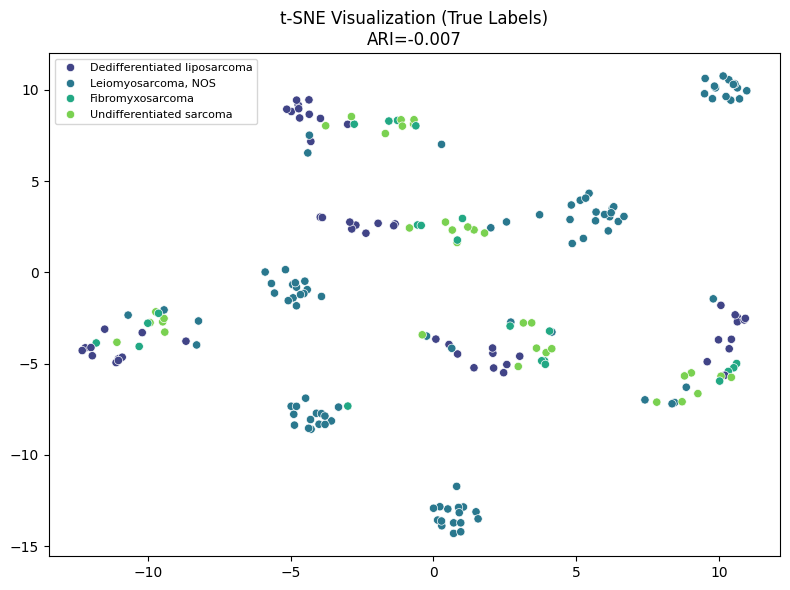

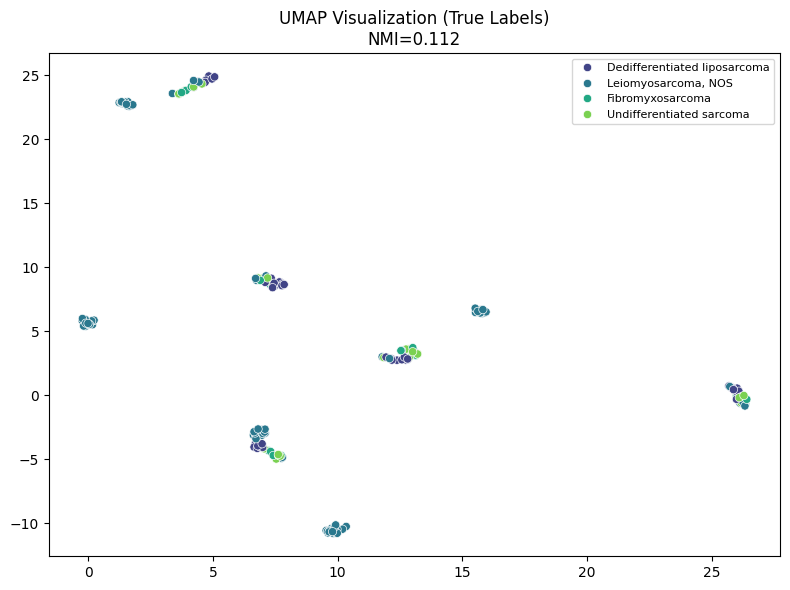

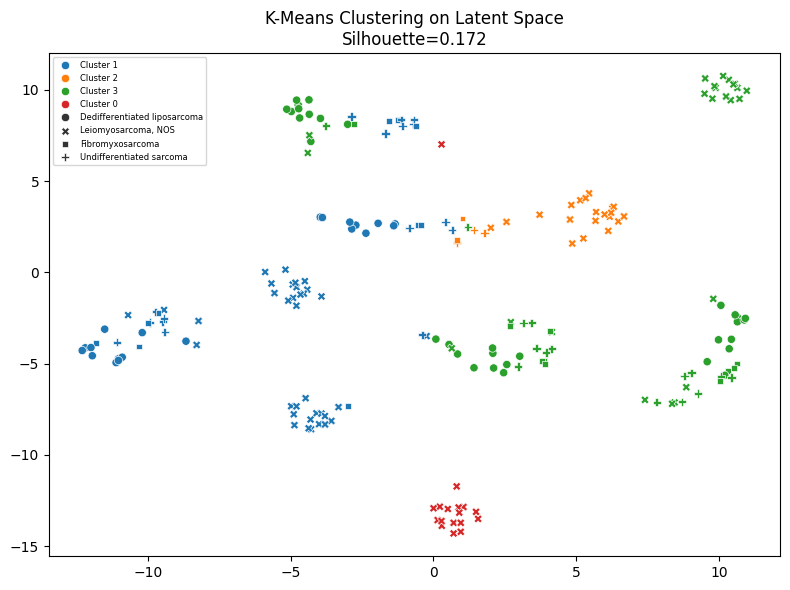

In [10]:

from sklearn.utils.class_weight import compute_class_weight

def train_and_evaluate(rna, meth, cnv, Y, class_names):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    
    # Store results for all classifiers

    results = {
        'xgb': [], 'svm': [], 'lr': [], 'knn': [],
        'f1_macro': [], 'f1_micro': [], 'precision': [], 'recall': [], 'accuracy': []
    }
    
    # Store aggregated latent data for clustering
    all_latent = []
    all_targets = []
    
    for fold, (t_idx, v_idx) in enumerate(kf.split(rna, Y)):
        print(f"\n{'='*20} FOLD {fold+1} {'='*20}")
        
        # Prep Data
        (tr_r, val_r, tr_m, val_m, tr_c, val_c, y_tr, y_val) = prepare_fold(t_idx, v_idx, rna, meth, cnv, Y)
        
        # --- A. Calculate Class Weights for Imbalance ---
        y_tr_np = y_tr.cpu().numpy()
        classes_unique = np.unique(y_tr_np)
        weights = compute_class_weight('balanced', classes=classes_unique, y=y_tr_np)
        class_weights_tensor = torch.FloatTensor(weights).to(DEVICE)
        
        # Dims
        dim_r = tr_r.shape[1]; dim_m = tr_m.shape[1]; dim_c = tr_c.shape[1]
        
        # --- B. Initialize Simplified Models ---
        enc_r = PerOmicEncoder(dim_r, BEST_PARAMS['latent_dim'], BEST_PARAMS['hidden_dim'], BEST_PARAMS['dropout_rate']).to(DEVICE)
        enc_m = PerOmicEncoder(dim_m, BEST_PARAMS['latent_dim'], BEST_PARAMS['hidden_dim'], BEST_PARAMS['dropout_rate']).to(DEVICE)
        enc_c = PerOmicEncoder(dim_c, BEST_PARAMS['latent_dim'], BEST_PARAMS['hidden_dim'], BEST_PARAMS['dropout_rate']).to(DEVICE)
        
        # Fusion
        fusion = SimpleFusionNet(BEST_PARAMS['latent_dim'], 4, BEST_PARAMS['hidden_dim'], BEST_PARAMS['dropout_rate']).to(DEVICE)
        
        # Optim
        params = list(enc_r.parameters()) + list(enc_m.parameters()) + list(enc_c.parameters()) + list(fusion.parameters())

        opt = optim.AdamW(params, lr=BEST_PARAMS['lr'], weight_decay=BEST_PARAMS['weight_decay'])

        scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=5)
        
        # --- C. Simplified Losses (No MSE) ---
        con_crit = SupervisedContrastiveLoss(temperature=BEST_PARAMS['temperature'])
        cls_crit = WeightedFocalLoss(gamma=BEST_PARAMS['focal_gamma'], alpha=class_weights_tensor)
        
        # Train Loop
        train_hist = []
        val_hist = []
        

        EPOCHS = 150
        patience = 15
        cur_patience = 0
        best_val_loss = float('inf')
        best_state_dict = None
        
        for ep in range(EPOCHS):
            # --- TRAIN ---
            enc_r.train(); enc_m.train(); enc_c.train(); fusion.train()
            
            # Forward (No Decoder)
            zr = enc_r(tr_r)
            zm = enc_m(tr_m)
            zc = enc_c(tr_c)
            
            z_fused, proj, logits = fusion(zr, zm, zc)
            
            # Loss now strictly focuses on class separation, not omic reconstruction
            l_con = con_crit(proj, y_tr)
            l_cls = cls_crit(logits, y_tr)
            
            loss = l_con + l_cls # Equal weighting 
                   
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            # --- VAL (Check for Overfitting) ---
            enc_r.eval(); enc_m.eval(); enc_c.eval(); fusion.eval()
            with torch.no_grad():
                vzr = enc_r(val_r)
                vzm = enc_m(val_m)
                vzc = enc_c(val_c)
                vz_fused, vproj, vlogits = fusion(vzr, vzm, vzc)
                
                vl_cls = cls_crit(vlogits, y_val)
                vl_con = con_crit(vproj, y_val) 
                
                val_total = vl_cls + vl_con 
            

            train_hist.append(loss.item())
            val_hist.append(val_total.item())
            
            # Step Scheduler
            scheduler.step(val_total)
            

            if ep % 20 == 0:
                print(f"  Ep {ep}: Train={loss.item():.4f} (Con={l_con.item():.2f}, Cls={l_cls.item():.2f}) | Val={val_total.item():.4f}")

            # --- Early Stopping Logic ---
            # 1. Check for Improvement
            if val_total < best_val_loss:
                best_val_loss = val_total
                best_state_dict = {
                    'enc_r': enc_r.state_dict(),
                    'enc_m': enc_m.state_dict(),
                    'enc_c': enc_c.state_dict(),
                    'fusion': fusion.state_dict()
                }
                cur_patience = 0
            else:
                cur_patience += 1
            
            # 2. Check for Overfitting (Val Loss significantly higher than Train Loss)
            # Only check if training has stabilized a bit (e.g., after 20 epochs)
            if ep > 20:
                overfit_pct = ((val_total.item() - loss.item()) / (loss.item() + 1e-6)) * 100
                if overfit_pct > 20.0: # Stop if Val is >20% worse than Train
                    print(f"  [Early Stopping] Overfitting detected at Ep {ep}. Diff: {overfit_pct:.2f}%")
                    break
            

            # 3. Patience Limit
            if cur_patience >= patience:
                print(f"  [Early Stopping] No improvement for {patience} epochs. Stopping at Ep {ep}.")
                # Calculate final stats at stop
                overfit_pct = ((val_total.item() - loss.item()) / (loss.item() + 1e-6)) * 100
                print(f"  [Evaluate] Final (Stop) Train: {loss.item():.4f}, Val: {val_total.item():.4f}, Diff: {overfit_pct:.2f}%")
                break
        
        # Restore Best Weights
        if best_state_dict is not None:
            enc_r.load_state_dict(best_state_dict['enc_r'])
            enc_m.load_state_dict(best_state_dict['enc_m'])
            enc_c.load_state_dict(best_state_dict['enc_c'])
            fusion.load_state_dict(best_state_dict['fusion'])
            print(f"  Restored best model from epoch with Val Loss: {best_val_loss:.4f}")

        # Overfitting Metric on restored model (approx) or last step
        # Since we restore, we might want to check the stats of the BEST epoch if we saved them,
        # but here we can just report the last step's diff as an indicator of where it headed,
        # OR re-evaluate the best model. Let's re-evaluate quickly to get EXACT best stats.
        enc_r.eval(); enc_m.eval(); enc_c.eval(); fusion.eval()
        with torch.no_grad():
             # Recalculate losses for the restored best model to print exact stats
             vzr = enc_r(val_r); vzm = enc_m(val_m); vzc = enc_c(val_c)
             vz_fused, vproj, vlogits = fusion(vzr, vzm, vzc)
             
             # Re-run train fwd to get train loss for this best state? 
             # Expensive/Complicated due to batches. We'll skip exact train loss recalc 
             # and rely on the last seen or just print Val loss.
             pass

        
        # --- Extract Embeddings for ML ---
        enc_r.eval(); enc_m.eval(); enc_c.eval(); fusion.eval()
        with torch.no_grad():
            zr = enc_r(tr_r); zm = enc_m(tr_m); zc = enc_c(tr_c)
            tr_emb, _, _ = fusion(zr, zm, zc)
            X_train_emb = tr_emb.cpu().numpy()
            y_train_np = y_tr.cpu().numpy()
            
            vzr = enc_r(val_r); vzm = enc_m(val_m); vzc = enc_c(val_c)
            val_emb, _, _ = fusion(vzr, vzm, vzc)
            X_val_emb = val_emb.cpu().numpy()
            y_val_np = y_val.cpu().numpy()
            
            # Store for clustering
            all_latent.append(X_val_emb)
            all_targets.append(y_val_np)
            
        # --- Train Classical Classifiers & Get Detailed Metrics (Using SVM as main for example) ---
        


        # --- Train Classical Classifiers ---
        
        # SVM (Main Classifier)
        svm_clf = SVC(kernel='rbf', C=1.0, probability=True, random_state=SEED)
        svm_clf.fit(X_train_emb, y_train_np)
        svm_preds = svm_clf.predict(X_val_emb)
        svm_f1 = f1_score(y_val_np, svm_preds, average='macro')
        results['svm'].append(svm_f1)
        
        # Metrics for SVM
        acc = accuracy_score(y_val_np, svm_preds)
        prec = precision_score(y_val_np, svm_preds, average='macro')
        rec = recall_score(y_val_np, svm_preds, average='macro')
        f1_mic = f1_score(y_val_np, svm_preds, average='micro')
        
        results['accuracy'].append(acc)
        results['precision'].append(prec)
        results['recall'].append(rec)
        results['f1_macro'].append(svm_f1)
        results['f1_micro'].append(f1_mic)
        
        print(f"   -> Fold F1 (SVM): {svm_f1:.4f}")

    # Concatenate all latent for clustering analysis
    all_latent_np = np.concatenate(all_latent, axis=0)
    all_targets_np = np.concatenate(all_targets, axis=0)
    
    return results, all_latent_np, all_targets_np

# Load & Run
if __name__ == "__main__":
    try:
        rna, meth, cnv, Y, classes = load_data()
        results, all_latent, all_targets = train_and_evaluate(rna, meth, cnv, Y, classes)
        
        print(f"\n{'='*30}")
        print("FINAL AVERAGED CLASSIFICATION RESULTS (SVM)")
        print(f"{'='*30}")
        print(f"F1 Macro:  {np.mean(results['f1_macro']):.4f} +/- {np.std(results['f1_macro']):.4f}")
        print(f"F1 Micro:  {np.mean(results['f1_micro']):.4f}")
        print(f"Precision: {np.mean(results['precision']):.4f}")
        print(f"Recall:    {np.mean(results['recall']):.4f}")
        print(f"Accuracy:  {np.mean(results['accuracy']):.4f}")
        

        print(f"\nOther Classifiers (F1-Macro):")
        if HAS_XGB: print(f"XGBoost: {np.mean(results['xgb']):.4f}")
        print(f"LogReg:  {np.mean(results['lr']):.4f}")
        print(f"KNN:     {np.mean(results['knn']):.4f}")
        
        # --- CLUSTERING ANALYSIS ---
        print(f"\n{'='*30}")
        print("CLUSTERING ANALYSIS")
        print(f"{'='*30}")
        
        # Metrics
        sil_true = silhouette_score(all_latent, all_targets)
        
        kmeans = KMeans(n_clusters=len(classes), random_state=SEED)
        km_preds = kmeans.fit_predict(all_latent)
        
        sil_km = silhouette_score(all_latent, km_preds)
        ari = adjusted_rand_score(all_targets, km_preds)
        nmi = normalized_mutual_info_score(all_targets, km_preds)
        
        print(f"Silhouette (True Labels): {sil_true:.4f}")
        print(f"Silhouette (K-Means):     {sil_km:.4f}")
        print(f"ARI Score:                {ari:.4f}")
        print(f"NMI Score:                {nmi:.4f}")
        

        # --- VISUALIZATION (Individual Plots) ---
        print("\nGenerating Plots...")
        
        # 1. t-SNE Plot
        plt.figure(figsize=(8, 6))
        tsne = TSNE(n_components=2, random_state=SEED, perplexity=30)
        z_tsne = tsne.fit_transform(all_latent)
        sns.scatterplot(x=z_tsne[:,0], y=z_tsne[:,1], hue=[classes[i] for i in all_targets], palette='viridis')
        plt.title(f't-SNE Visualization (True Labels)\nARI={ari:.3f}')
        plt.legend(prop={'size': 8})
        plt.tight_layout()
        plt.show()
        
        # 2. UMAP Plot
        plt.figure(figsize=(8, 6))
        if HAS_UMAP:
            reducer = umap.UMAP(random_state=SEED)
            z_umap = reducer.fit_transform(all_latent)
            sns.scatterplot(x=z_umap[:,0], y=z_umap[:,1], hue=[classes[i] for i in all_targets], palette='viridis')
            plt.title(f'UMAP Visualization (True Labels)\nNMI={nmi:.3f}')
            plt.legend(prop={'size': 8})
            plt.tight_layout()
            plt.show()
        else:
            print(" - UMAP not installed, skipping UMAP plot.")
            plt.close()
            
        # 3. K-Means Clusters Plot
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=z_tsne[:,0], y=z_tsne[:,1], hue=[f"Cluster {i}" for i in km_preds], palette='tab10', style=[classes[i] for i in all_targets])
        plt.title(f'K-Means Clustering on Latent Space\nSilhouette={sil_km:.3f}')
        plt.legend(prop={'size': 6})
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(e)
        import traceback
        traceback.print_exc()
